#Assignment Week 6

#AI Informed Search

Python code for Artificial Intelligence: Foundations of Computational Agents


David L. Poole and Alan K. Mackworth

In [ ]:
class Search_problem(object):
    """A search problem consists of:
    * a start node
    * a neighbors function that gives the neighbors of a node
    * a specification of a goal
    * a (optional) heuristic function.
    The methods must be overridden to define a search problem."""

    def start_node(self):
        """returns start node"""
        raise NotImplementedError("start_node")   # abstract method

    def is_goal(self,node):
        """is True if node is a goal"""
        raise NotImplementedError("is_goal")   # abstract method

    def neighbors(self,node):
        """returns a list of the arcs for the neighbors of node"""
        raise NotImplementedError("neighbors")   # abstract method

    def heuristic(self,n):
        """Gives the heuristic value of node n.
        Returns 0 if not overridden."""
        return 0

In [ ]:
class Arc(object):
    """An arc has a from_node and a to_node node and a (non-negative) cost"""
    def __init__(self, from_node, to_node, cost=1, action=None):
        assert cost >= 0, ("Cost cannot be negative for"+
                           str(from_node)+"->"+str(to_node)+", cost: "+str(cost))
        self.from_node = from_node
        self.to_node = to_node
        self.action = action
        self.cost=cost

    def __repr__(self):
        """string representation of an arc"""
        if self.action:
            return str(self.from_node)+" --"+str(self.action)+"--> "+str(self.to_node)
        else:
            return str(self.from_node)+" --> "+str(self.to_node)

In [ ]:
class Search_problem_from_explicit_graph(Search_problem):
    """A search problem consists of:
    * a list or set of nodes
    * a list or set of arcs
    * a start node
    * a list or set of goal nodes
    * a dictionary that maps each node into its heuristic value.
    """

    def __init__(self, nodes, arcs, start=None, goals=set(), hmap={}):
        self.neighs = {}
        self.nodes = nodes
        for node in nodes:
            self.neighs[node]=[]
        self.arcs = arcs
        for arc in arcs:
            self.neighs[arc.from_node].append(arc)
        self.start = start
        self.goals = goals
        self.hmap = hmap

    def start_node(self):
        """returns start node"""
        return self.start

    def is_goal(self,node):
        """is True if node is a goal"""
        return node in self.goals

    def neighbors(self,node):
        """returns the neighbors of node"""
        return self.neighs[node]

    def heuristic(self,node):
        """Gives the heuristic value of node n.
        Returns 0 if not overridden in the hmap."""
        if node in self.hmap:
            return self.hmap[node]
        else:
            return 0

    def __repr__(self):
        """returns a string representation of the search problem"""
        res=""
        for arc in self.arcs:
            res += str(arc)+".  "
        return res

    def neighbor_nodes(self,node):
        """returns an iterator over the neighbors of node"""
        return (path.to_node for path in self.neighs[node])

In [ ]:
class Path(object):
    """A path is either a node or a path followed by an arc"""

    def __init__(self,initial,arc=None):
        """initial is either a node (in which case arc is None) or
        a path (in which case arc is an object of type Arc)"""
        self.initial = initial
        self.arc=arc
        if arc is None:
            self.cost=0
        else:
            self.cost = initial.cost+arc.cost

    def end(self):
        """returns the node at the end of the path"""
        if self.arc is None:
            return self.initial
        else:
            return self.arc.to_node

    def nodes(self):
        """enumerates the nodes for the path.
        This starts at the end and enumerates nodes in the path backwards."""
        current = self
        while current.arc is not None:
            yield current.arc.to_node
            current = current.initial
        yield current.initial

    def initial_nodes(self):
        """enumerates the nodes for the path before the end node.
        This starts at the end and enumerates nodes in the path backwards."""
        if self.arc is not None:
            for nd in self.initial.nodes(): yield nd     # could be "yield from"

    def __repr__(self):
        """returns a string representation of a path"""
        if self.arc is None:
            return str(self.initial)
        elif self.arc.action:
            return (str(self.initial)+"\n   --"+str(self.arc.action)
                    +"--> "+str(self.arc.to_node))
        else:
            return str(self.initial)+" --> "+str(self.arc.to_node)

In [ ]:
class Displayable(object):
    """Class that uses 'display'.
    The amount of detail is controlled by max_display_level
    """
    max_display_level = 1   # can be overridden in subclasses

    def display(self,level,*args,**nargs):
        """print the arguments if level is less than or equal to the
        current max_display_level.
        level is an integer.
        the other arguments are whatever arguments print can take.
        """
        if level <= self.max_display_level:
            print(*args, **nargs)  ##if error you are using Python2 not Python3

def visualize(func):
    """A decorator for algorithms that do interactive visualization.
    Ignored here.
    """
    return func

In [ ]:
import heapq        # part of the Python standard library

class FrontierPQ(object):
    """A frontier consists of a priority queue (heap), frontierpq, of
        (value, index, path) triples, where
    * value is the value we want to minimize (e.g., path cost + h).
    * index is a unique index for each element
    * path is the path on the queue
    Note that the priority queue always returns the smallest element.
    """

    def __init__(self):
        """constructs the frontier, initially an empty priority queue
        """
        self.frontier_index = 0  # the number of items ever added to the frontier
        self.frontierpq = []  # the frontier priority queue

    def empty(self):
        """is True if the priority queue is empty"""
        return self.frontierpq == []

    def add(self, path, value):
        """add a path to the priority queue
        value is the value to be minimized"""
        self.frontier_index += 1    # get a new unique index
        heapq.heappush(self.frontierpq,(value, -self.frontier_index, path))

    def pop(self):
        """returns and removes the path of the frontier with minimum value.
        """
        (_,_,path) = heapq.heappop(self.frontierpq)
        return path

    def count(self,val):
        """returns the number of elements of the frontier with value=val"""
        return sum(1 for e in self.frontierpq if e[0]==val)

    def __repr__(self):
        """string representation of the frontier"""
        return str([(n,c,str(p)) for (n,c,p) in self.frontierpq])

    def __len__(self):
        """length of the frontier"""
        return len(self.frontierpq)

    def __iter__(self):
        """iterate through the paths in the frontier"""
        for (_,_,path) in self.frontierpq:
            yield path

#Problem 1

In [ ]:
problem1 = Search_problem_from_explicit_graph(
    {'a','b','c','d','g'},
    [Arc('a','b',1), Arc('a','c',3), Arc('b','d',3), Arc('b','c',1),
        Arc('c','d',1), Arc('c','g',3), Arc('d','g',1)],
    start = 'a',
    goals = {'g'})

In [ ]:
problem1

a --> b.  a --> c.  b --> d.  b --> c.  c --> d.  c --> g.  d --> g.  

##Graph

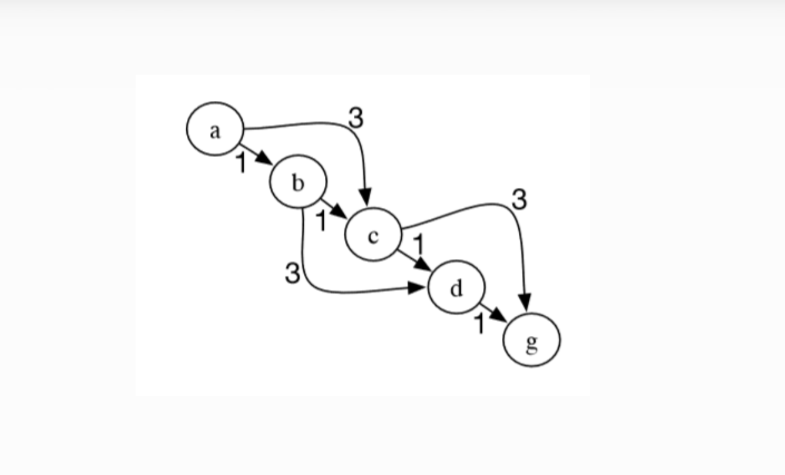

##Tree

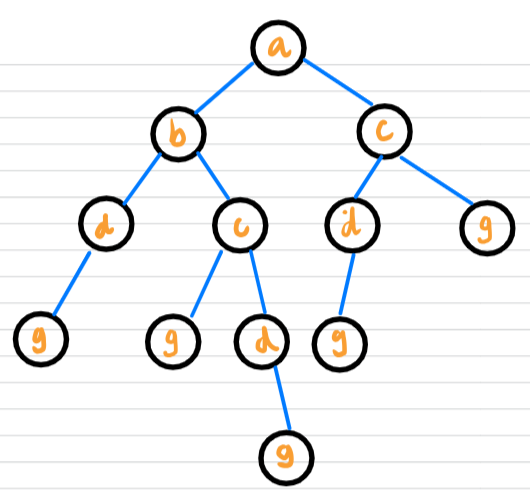

##Depth First Search

In [ ]:
#DFS
class Searcher(Displayable):
    """returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    This does depth-first search unless overridden
    """
    def __init__(self, problem):
        """creates a searcher from a problem
        """
        self.problem = problem
        self.initialize_frontier()
        self.num_expanded = 0
        self.add_to_frontier(Path(problem.start_node()))
        super().__init__()

    def initialize_frontier(self):
        self.frontier = []

    def empty_frontier(self):
        return self.frontier == []

    def add_to_frontier(self,path):
        self.frontier.append(path)

    @visualize
    def search(self):
        """returns (next) path from the problem's start node
        to a goal node.
        Returns None if no path exists.
        """
        while not self.empty_frontier():
            path = self.frontier.pop()
            self.display(2, "Expanding:",path,"(cost:",path.cost,")")
            self.num_expanded += 1
            if self.problem.is_goal(path.end()):    # solution found
                self.display(1, self.num_expanded, "paths have been expanded and",
                            len(self.frontier), "paths remain in the frontier")
                self.solution = path   # store the solution found
                return path
            else:
                neighs = self.problem.neighbors(path.end())
                self.display(3,"Neighbors are", neighs)
                for arc in reversed(neighs):
                    self.add_to_frontier(Path(path,arc))
                self.display(3,"Frontier:",self.frontier)
        self.display(1,"No (more) solutions. Total of",
                     self.num_expanded,"paths expanded.")


In [ ]:
def test(SearchClass):
    print("Testing problem 1:")
    schr1 = SearchClass(problem1)
    path1 = schr1.search()
    print("Path found:",path1)
    print("Passed unit test")

In [ ]:
test(Searcher)

Testing problem 1:
4 paths have been expanded and 2 paths remain in the frontier
Path found: a --> b --> d --> g
Passed unit test


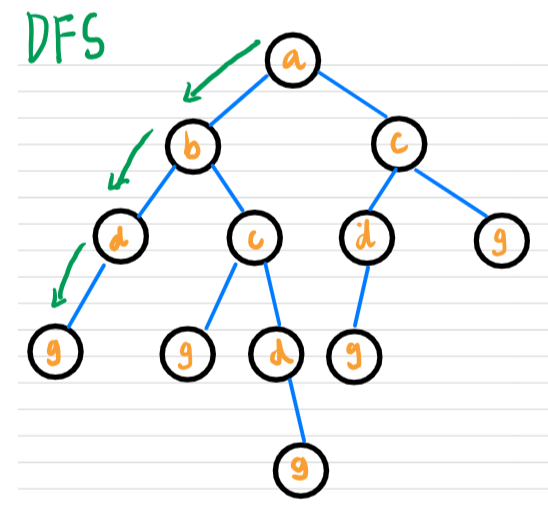

##Greedy

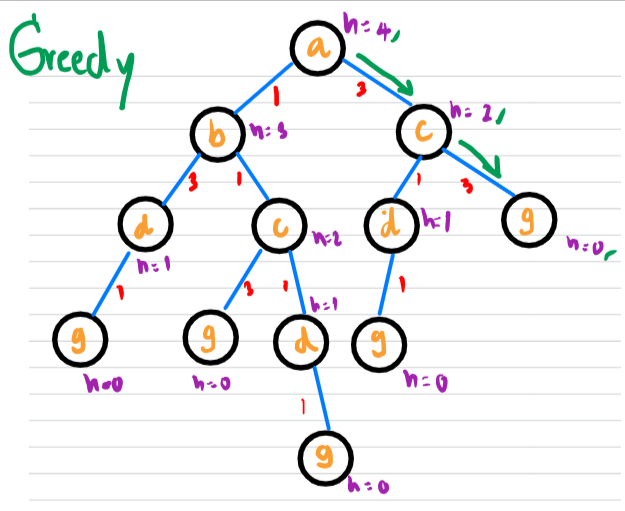

##A*

In [ ]:
class AStarSearcher(Searcher):
    """returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """

    def __init__(self, problem):
        super().__init__(problem)

    def initialize_frontier(self):
        self.frontier = FrontierPQ()

    def empty_frontier(self):
        return self.frontier.empty()

    def add_to_frontier(self,path):
        """add path to the frontier with the appropriate cost"""
        value = path.cost+self.problem.heuristic(path.end())
        self.frontier.add(path, value)

NameError: name 'Searcher' is not defined

In [ ]:
def test(SearchClass):
    print("Testing problem 1:")
    schr1 = SearchClass(problem1)
    path1 = schr1.search()
    print("Path found:",path1)
    assert list(path1.nodes()) == ['g','d','c','b','a'], "Shortest path not found in problem1"
    print("Passed unit test")

In [ ]:
test(AStarSearcher)

Testing problem 1:
7 paths have been expanded and 4 paths remain in the frontier
Path found: a --> b --> c --> d --> g
Passed unit test


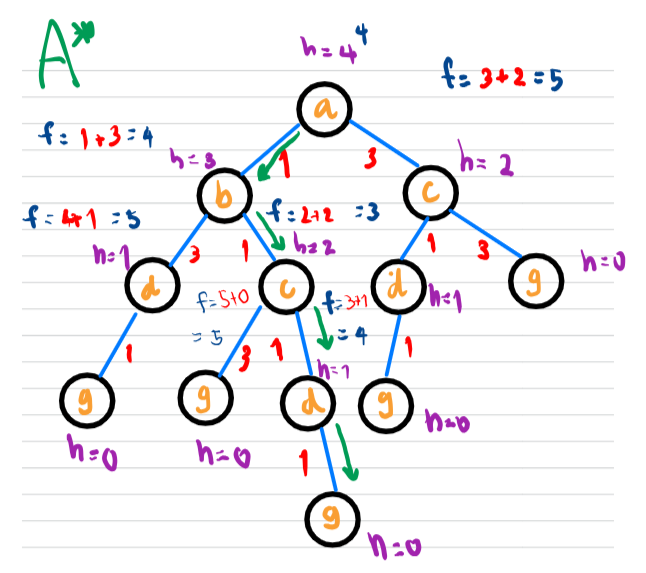

#Problem 2

In [ ]:
problem2 = Search_problem_from_explicit_graph(
    {'a','b','c','d','e','g','h','j'},
    [Arc('a','b',1), Arc('b','c',3), Arc('b','d',1), Arc('d','e',3),
        Arc('d','g',1), Arc('a','h',3), Arc('h','j',1)],
    start = 'a',
    goals = {'g'})

In [ ]:
problem2

a --> b.  b --> c.  b --> d.  d --> e.  d --> g.  a --> h.  h --> j.  

##Graph

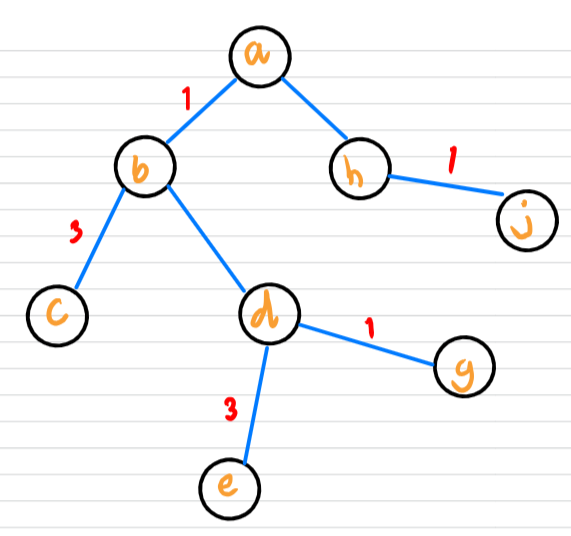

##Tree

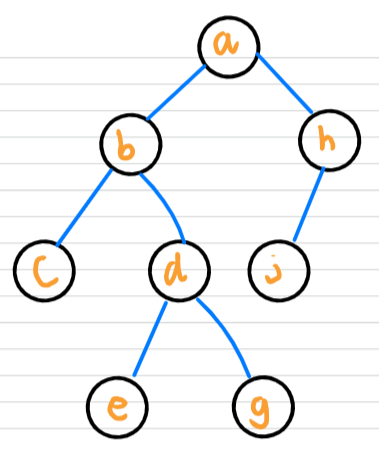

##Depth First Search

In [ ]:
def test2(SearchClass):
    print("Testing problem 2:")
    schr2 = SearchClass(problem2)
    path2 = schr2.search()
    print("Path found:",path2)
    assert list(path2.nodes()) == ['g','d','b','a'], "Shortest path not found in problem1"
    print("Passed unit test")

In [ ]:
test2(Searcher)

Testing problem 2:
6 paths have been expanded and 1 paths remain in the frontier
Path found: a --> b --> d --> g
Passed unit test


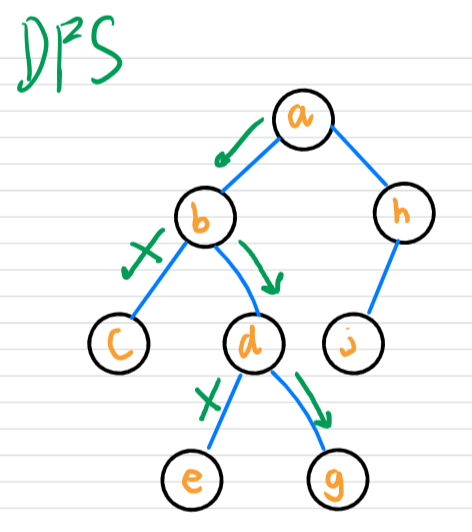

##Greedy

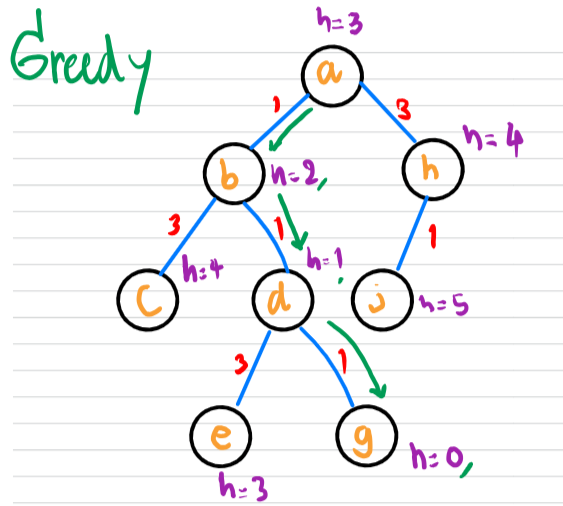

##A*

In [ ]:
test2(AStarSearcher)

Testing problem 2:
4 paths have been expanded and 3 paths remain in the frontier
Path found: a --> b --> d --> g
Passed unit test


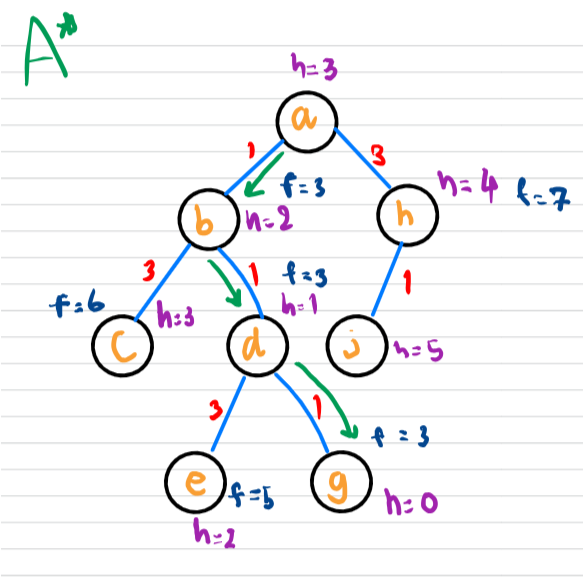